# Predicting COVID-19 ICU Admission Using Neural Network

## License

The original dataset is under **Attribution-NonCommercial 4.0 (International CC BY-NC 4.0)** license.

Dataset is free to **share** and **adapt** under the following terms:

* credit to the original article is given and any changes are indicated (nothing has been changed as of 30/11/2021)
* material is not used for commercial purposes 

Credit:

* original material is published on [Kaggle](https://www.kaggle.com/) and accessible [here](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19).

## Intro

This repository contains source code and report for a seminar paper in the context of the course *Machine Learning* in the winter semester 2021/2021 at Faculty of Computer and Information science, University of Ljubljana.

The dataset contains anonymized data from Hospital Sírio-Libanês, São Paulo and Brasilia. 

### Context (*copied from the above-mentioned Kaggle article*)
COVID-19 pandemic impacted the whole world, overwhelming healthcare systems - unprepared for such intense and lengthy request for ICU beds, professionals, personal protection equipment and healthcare resources.
Brazil recorded first COVID-19 case on February 26 and reached community transmission on March 20.

## Task

Predict admission to the ICU of confirmed COVID-19 cases.
Based on the data available, is it feasible to predict which patients will need intensive care unit support?
The aim is to provide tertiary and quarternary hospitals with the most accurate answer, so ICU resources can be arranged or patient transfer can be scheduled (*copied from Kaggle article*).

## Dataset

Data has been cleaned and scaled by column according to Min Max Scaler. In total, there are 54 features (expanded when pertinent to the mean, median, max, min, diff and relative diff). 

### Available Data

Features in the dataset can be grouped in four groups.



| Group | Amount of features |
| ----- | :------------------: |
| Demographics | 3 |
| Grouped diseases | 9 |
| Blood results | 36 |
| Vital signs | 6 |
| **Total**| **54** |



### Window Concept

Data for each patient has been grouped in five windows, each containing diagnostic results from the respective time window.



| Window      | Description |
| ----------- | ----------- |
| 0-2         | From 0 to 2 hours of the admission |
| 2-4         | From 2 to 4 hours of the admission |
| 4-6         | From 4 to 6 hours of the admission |
| 6-12        | From 6 to 12 hours of the admission |
| Above 12    | Above 12 hours from admission |



Kaggle article warns not to use data from the window where the target variable is 1. This means we need to manipulate our data a little. For example let's take a look at the following time tables:



| Window      | Patient admitted to ICU | Data can be used for modelling | Target variable |
| ----------- | :-----------: | :-----------: | :-----------: |
| 0-2         | False | True | 1 |
| 2-4         | False | True | 1 |
| 4-6         | False | True | 1 |
| 6-12        | True | False |  |
| Above 12    | True | False |  |



Patient is admitted in the fourth time window (6-12 from initial non-ICU admission). This means we can use data from the first three time windows with target variable being 1 (patient being admitted to the ICU ward).



| Window      | Patient admitted to ICU | Data can be used for modelling | Target variable |
| ----------- | :-----------: | :-----------: | :-----------: |
| 0-2         | False | True | 0 |
| 2-4         | False | True | 0 |
| 4-6         | False | True | 0 |
| 6-12        | False | True | 0 |
| Above 12    | False | True | 0 |



Patient is never admitted to the ICU, we can therefore use all time windows with target variable 0.

### Null Values

If we take a look at the following snippet from the original Kaggle article:

```
It is reasonable to assume that a patient who does not have a measurement recorded in a time window is clinically stable, potentially presenting vital signs and blood labs similar to neighboring windows. Therefore, one may fill the missing values using the next or previous entry. Attention to multicollinearity and zero variance issues in this data when choosing your algorithm.
```

We will be filling missing values from neighbouring cells, as specified in the snippet above.

## Import

Before you begin to run your code, you need to load all required modules. Simply execute the code block below. This block also enables Jupyter's auto-reloading feature, so you dont need to re-import modules whenever you change them.

In [76]:
# In order to import from the python file without hassle, we add the current
# directory to the python path
import sys; sys.path.append(".")

# Auto-reload
%load_ext autoreload
%autoreload 2

# Utilities module
from src.utilities import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Preparation

Instructions on how to set up the environment are specified in the [README](https://github.com/JakobSkornik/covid19-admission/blob/main/README.md) file.

The original dataset is provided in a single *xlsx* file. Let us first import the dataset and store it in a single pandas DataFrame.

In [77]:
# Load Excel into DataFrame
dataset = load_xlsx("data/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx")

# Print first 10 elements of DataFrame
dataset.head(10)

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1
5,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
6,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,1
7,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4-6,1
8,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.880952,-1.000000,-0.906832,-0.831132,-0.940967,-0.817204,-0.882574,-1.000000,6-12,1
9,1,1,90th,1,0.0,0.0,0.0,0.0,1.0,0.0,...,0.142857,-0.797980,0.315690,0.200359,-0.239515,0.645161,0.139709,-0.802317,ABOVE_12,1


Lets take a look at the datatypes present in this dataset.

In [78]:
dataset.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

The next thing we want to do, is to add the target variable to all the rows. If there's at least one positive value in the **ICU** column for a single patient, the target variable is 1.

First we obtain the target variable for every patient.

In [79]:
# Create a df with PATIENT_ID/TARGET columns
patient_target_df = get_target_variables(dataset)
patient_target_df.head(10)

,PATIENT_VISIT_IDENTIFIER,TARGET
0,0,1
1,1,1
2,2,1
3,3,0
4,4,0
5,5,0
6,6,0
7,7,0
8,8,0
9,9,0


Now we append target variable to each row of the **dataset** dataframe.

In [80]:
dataset = append_target_variable(dataset, patient_target_df)
dataset.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU,TARGET
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0,1
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0,1
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0,1
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0,1
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1,1


Now we can remove the rows, where dataset contains value 1 in the column **ICU**.

In [81]:
dataset = dataset[dataset.ICU != 1]
dataset.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU,TARGET
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0-2,0,1
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2-4,0,1
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0,1
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.0,NaN,NaN,NaN,NaN,-1.0,-1.0,6-12,0,1
10,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0-2,0,1


Next, we remove metadata column containing patient ID **PATIENT_VISIT_IDENTIFIER** and column **ICU**, since every row has the same ICU value 0.

In [82]:
dataset = dataset.drop(["PATIENT_VISIT_IDENTIFIER", "ICU"], axis=1)
dataset.head()

,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,TARGET
0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0-2,1
1,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2-4,1
2,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,1
3,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,-1.0,-1.0,NaN,NaN,NaN,NaN,-1.0,-1.0,6-12,1
10,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0-2,1


We still have to deal with null values. As specified above, we will fill null values with neighbouring values. We can take advantage of the **pd.DataFrame.fillna** method.

In [83]:
dataset = dataset.fillna(method="bfill")

There are still whitespace characters in column names, so we replace them with underscores.

In [84]:
dataset.columns = dataset.columns.str.replace(" ", "_")
dataset.head()

,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE_GROUPING_1,DISEASE_GROUPING_2,DISEASE_GROUPING_3,DISEASE_GROUPING_4,DISEASE_GROUPING_5,DISEASE_GROUPING_6,HTN,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,TARGET
0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,0-2,1
1,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,2-4,1
2,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,-1.0,-1.000000,-0.515528,-0.351328,-0.747001,-0.756272,-1.0,-1.000000,4-6,1
3,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,-1.0,-1.000000,-0.515528,-0.351328,-0.747001,-0.756272,-1.0,-1.000000,6-12,1
10,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.0,-0.961262,0-2,1


We also need to encode the **AGE_PERCENTIL** column. We can see that there are 10 distinct values.

In [85]:
dataset.AGE_PERCENTIL.unique()

array(['60th', '10th', '40th', '70th', '20th', '50th', '80th', '30th',
       '90th', 'Above 90th'], dtype=object)

We can use pandas.get_dummies method, which will map a single column with n possible values, into n different binary columns. Column representing the original value, will contain value 1.

For example the following column:

| Value |
| :----: |
| a |
| b |
| c |
| a |
| a |

will get mapped into:

| Value_a | Value_b | Value_c |
| :---: | :---: | :---: |
| 1 | 0 | 0 |
| 0 | 1 | 0 |
| 0 | 0 | 1 |
| 1 | 0 | 0 |
| 1 | 0 | 0 |

In [86]:
dataset = get_dummies(dataset, cols=["AGE_PERCENTIL"])
dataset.head()

,AGE_ABOVE65,GENDER,DISEASE_GROUPING_1,DISEASE_GROUPING_2,DISEASE_GROUPING_3,DISEASE_GROUPING_4,DISEASE_GROUPING_5,DISEASE_GROUPING_6,HTN,IMMUNOCOMPROMISED,...,TARGET,AGE_PERCENTIL_20th,AGE_PERCENTIL_30th,AGE_PERCENTIL_40th,AGE_PERCENTIL_50th,AGE_PERCENTIL_60th,AGE_PERCENTIL_70th,AGE_PERCENTIL_80th,AGE_PERCENTIL_90th,AGE_PERCENTIL_Above 90th
0,1,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1,0,0,0,0,1,0,0,0,0
1,1,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1,0,0,0,0,1,0,0,0,0
2,1,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1,0,0,0,0,1,0,0,0,0
3,1,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1,0,0,0,0,1,0,0,0,0
10,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0


The final non-numeric column is the **WINDOW** column. Using this column, we can create 6 different datasets. There are five windows, so we can use each distinct value as a separate dataset and an additional dataset with all time windows. I will show the example for window 2-4. Keep in mind, when we create a dataset for a window, all previous windows must be included aswell.

After we extract a dataset for a desired window, **WINDOW** column can be dropped.

All datasets will then be created and stored in a new object, with all required metadata using a helper method.

In [87]:
window_24_dataset = dataset[(dataset.WINDOW == "0-2") | (dataset.WINDOW == "2-4")]
window_24_dataset = window_24_dataset.drop("WINDOW", axis=1)
window_24_dataset.head()

,AGE_ABOVE65,GENDER,DISEASE_GROUPING_1,DISEASE_GROUPING_2,DISEASE_GROUPING_3,DISEASE_GROUPING_4,DISEASE_GROUPING_5,DISEASE_GROUPING_6,HTN,IMMUNOCOMPROMISED,...,TARGET,AGE_PERCENTIL_20th,AGE_PERCENTIL_30th,AGE_PERCENTIL_40th,AGE_PERCENTIL_50th,AGE_PERCENTIL_60th,AGE_PERCENTIL_70th,AGE_PERCENTIL_80th,AGE_PERCENTIL_90th,AGE_PERCENTIL_Above 90th
0,1,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1,0,0,0,0,1,0,0,0,0
1,1,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1,0,0,0,0,1,0,0,0,0
10,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
11,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
15,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,1,0,0,0,0,0,0


Lets make sure that the datatypes of the curated dataset are all numeric.

In [88]:
window_24_dataset.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('int32'), dtype('uint8')],
      dtype=object)

We can now apply this data preparation again, this time for all time windows and for different fill methods separately in a script. The final dictionary is structured as follows:

* **datasets**: *dict*
  * **ffill_datasets**: *dict*
    * **window_0_2**: *pd.Dataframe*
    * **window_2_4**: *pd.DataFrame*
    * **window_4_6**: *pd.DataFrame*
    * **window_6_12**: *pd.DataFrame*
    * **window_all**: *pd.DataFrame*
  * **bfill_datasets**: *dict*
    * . . .

In [89]:
datasets = get_datasets()

## Neural Network

The first question as to why one would want to design a neural network by hand, can be answered easily; to understand how such algorithms work at a deep level and because it's fun.

The whole neural network is designed as a package, that we can use in this notebook. We will start with a simple stochastic gradient descent backpropagation algorithm.

The first step is to desgin a simple neural network thats capable of approximating some basic boolean functions.

In [90]:
# In order to import from the python file without hassle, we add the current
# directory to the python path
import sys; sys.path.append(".")

# Auto-reload
%load_ext autoreload
%autoreload 2

import json
from src.utilities import *
from src.neural_network.basic import BasicNeuralNetwork

datasets = json.load(open("data/datasets.json"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
# Create a neural network
basic5_AND = BasicNeuralNetwork(
    input_size=2,
    output_size=2,
    iterations=2000,
    logs=True,
    log_frequency=200,
    alpha=0.01,
    alpha_decay=0.0001,
    layer_size=5
)

# Create dataset
X_and = [
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
]

# AND target values
y_and = one_hot([0, 0, 0, 1], 2)

# Train on the dataset
basic5_AND.train(X_and, y_and)

# Evaluate model
basic5_AND_confusion_matrix = evaluate_custom(X_and, y_and, basic5_AND)

0: loss: 0.6909, accuracy: 0.75, learning_rate: 0.01
200: loss: 0.5092, accuracy: 0.75, learning_rate: 0.0098
400: loss: 0.43, accuracy: 0.75, learning_rate: 0.0096
600: loss: 0.3581, accuracy: 1.0, learning_rate: 0.0094
800: loss: 0.294, accuracy: 1.0, learning_rate: 0.0093
1000: loss: 0.2393, accuracy: 1.0, learning_rate: 0.0091
1200: loss: 0.1942, accuracy: 1.0, learning_rate: 0.0089
1400: loss: 0.1582, accuracy: 1.0, learning_rate: 0.0088
1600: loss: 0.1301, accuracy: 1.0, learning_rate: 0.0086
1800: loss: 0.1081, accuracy: 1.0, learning_rate: 0.0085
Finished learning. Accuracy: 1.0.
RESULTS:

    TP: 1,
    TN: 3,
    FP: 0,
    FN: 0
    accuracy: 4 / 4 = 100.0%
    sensitivity: 1.0
    specificity: 1.0
    


Neural network seems to work for an AND method. Let's try XOR.

In [92]:
# Create a neural network
basic5_XOR = BasicNeuralNetwork(
    input_size=2,
    output_size=2,
    iterations=2000,
    logs=True,
    log_frequency=200,
    alpha=0.01,
    alpha_decay=0.001,
    layer_size=5
)

# Create dataset
X_xor = [
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
]

# XOR target values
y_xor = one_hot([0, 1, 1, 0], 2)

# Train on the dataset
basic5_XOR.train(X_xor, y_xor)

# Evaluate model
basic5_XOR_confusion_matrix = evaluate_custom(X_xor, y_xor, basic5_XOR)

0: loss: 0.6612, accuracy: 0.75, learning_rate: 0.01
200: loss: 0.5854, accuracy: 0.75, learning_rate: 0.0083
400: loss: 0.5431, accuracy: 1.0, learning_rate: 0.0071
600: loss: 0.5093, accuracy: 1.0, learning_rate: 0.0063
800: loss: 0.4797, accuracy: 1.0, learning_rate: 0.0056
1000: loss: 0.4508, accuracy: 1.0, learning_rate: 0.005
1200: loss: 0.4222, accuracy: 1.0, learning_rate: 0.0045
1400: loss: 0.3972, accuracy: 1.0, learning_rate: 0.0042
1600: loss: 0.3735, accuracy: 1.0, learning_rate: 0.0038
1800: loss: 0.3511, accuracy: 1.0, learning_rate: 0.0036
Finished learning. Accuracy: 1.0.
RESULTS:

    TP: 2,
    TN: 2,
    FP: 0,
    FN: 0
    accuracy: 4 / 4 = 100.0%
    sensitivity: 1.0
    specificity: 1.0
    


Let's use our neural network on the actual dataset.

In [93]:
dataset = pd.DataFrame(json.loads(datasets["window_all"]))

X = dataset.drop("TARGET", axis=1).to_numpy()

y = dataset[["TARGET"]].to_numpy()
y = one_hot(y.T[0], 2)

0: loss: 0.6925, accuracy: 0.6766, learning_rate: 0.01
200: loss: 0.6392, accuracy: 0.6766, learning_rate: 0.0098
400: loss: 0.6308, accuracy: 0.6766, learning_rate: 0.0096
600: loss: 0.6288, accuracy: 0.6759, learning_rate: 0.0094
800: loss: 0.6277, accuracy: 0.6759, learning_rate: 0.0093
1000: loss: 0.6264, accuracy: 0.6759, learning_rate: 0.0091
1200: loss: 0.6251, accuracy: 0.6759, learning_rate: 0.0089
1400: loss: 0.6238, accuracy: 0.6773, learning_rate: 0.0088
1600: loss: 0.6208, accuracy: 0.678, learning_rate: 0.0086
1800: loss: 0.6161, accuracy: 0.6801, learning_rate: 0.0085
Finished learning. Accuracy: 0.6858156028368795.
RESULTS:

    TP: 29,
    TN: 937,
    FP: 13,
    FN: 431
    accuracy: 966 / 1410 = 68.51%
    sensitivity: 0.06
    specificity: 0.99
    


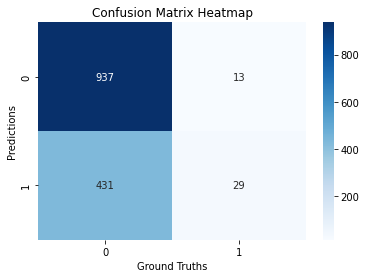

In [94]:
# Create a neural network
basic5_covid = BasicNeuralNetwork(
    input_size=X.shape[1],
    output_size=2,
    iterations=2000,
    logs=True,
    log_frequency=200,
    alpha=0.01,
    alpha_decay=0.0001,
    layer_size=5
)

basic5_covid.train(X, y)
basic5_covid_confusion_matrix = evaluate_custom(X, y, basic5_covid)

visualize_custom(basic5_covid_confusion_matrix)

At just 5 neurons in the hidden layer, the network pretty much reduces the problem to the majority class. Let's try increasing the number of neurons and compare results. Keep in mind, that the neural network uses **Stochastic Gradient Descent** optimization (same for previous examples).

0: loss: 9.3382, accuracy: 0.3291, learning_rate: 0.01
250: loss: 1.7538, accuracy: 0.7248, learning_rate: 0.0098
500: loss: 1.0124, accuracy: 0.7525, learning_rate: 0.0095
750: loss: 0.733, accuracy: 0.7681, learning_rate: 0.0093
1000: loss: 0.5739, accuracy: 0.7901, learning_rate: 0.0091
1250: loss: 0.479, accuracy: 0.7965, learning_rate: 0.0089
1500: loss: 0.4262, accuracy: 0.8035, learning_rate: 0.0087
1750: loss: 0.3954, accuracy: 0.8113, learning_rate: 0.0085
2000: loss: 0.3706, accuracy: 0.8241, learning_rate: 0.0083
2250: loss: 0.3553, accuracy: 0.8262, learning_rate: 0.0082
Finished learning. Accuracy: 0.8319148936170213.
RESULTS:

    TP: 324,
    TN: 848,
    FP: 102,
    FN: 136
    accuracy: 1172 / 1410 = 83.12%
    sensitivity: 0.7
    specificity: 0.89
    


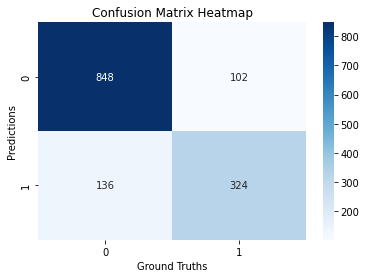

In [95]:
# Create a neural network
basic128_covid = BasicNeuralNetwork(
    input_size=X.shape[1],
    output_size=2,
    iterations=2500,
    logs=True,
    log_frequency=250,
    alpha=0.01,
    alpha_decay=0.0001,
    layer_size=128
)

basic128_covid.train(X, y)
basic128_covid_confusion_matrix = evaluate_custom(X, y, basic128_covid)

visualize_custom(basic128_covid_confusion_matrix)


This is a decent result. Let's try some other optimizers, namely **AdaGrad** and **Adam**.

#### AdaGrad

0: loss: 10.3927, accuracy: 0.3262, learning_rate: 0.01
250: loss: 1.931, accuracy: 0.7085, learning_rate: 0.0098
500: loss: 0.9168, accuracy: 0.7482, learning_rate: 0.0095
750: loss: 0.6217, accuracy: 0.7681, learning_rate: 0.0093
1000: loss: 0.486, accuracy: 0.783, learning_rate: 0.0091
1250: loss: 0.4101, accuracy: 0.8057, learning_rate: 0.0089
1500: loss: 0.3735, accuracy: 0.8163, learning_rate: 0.0087
1750: loss: 0.3506, accuracy: 0.8284, learning_rate: 0.0085
2000: loss: 0.3365, accuracy: 0.8404, learning_rate: 0.0083
2250: loss: 0.3301, accuracy: 0.844, learning_rate: 0.0082
Finished learning. Accuracy: 0.8468085106382979.
RESULTS:

    TP: 333,
    TN: 859,
    FP: 91,
    FN: 127
    accuracy: 1192 / 1410 = 84.54%
    sensitivity: 0.72
    specificity: 0.9
    


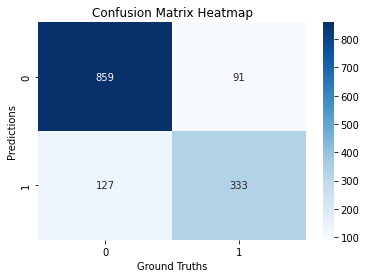

In [96]:
# Create a neural network
adagrad128_covid = BasicNeuralNetwork(
    input_size=X.shape[1],
    output_size=2,
    iterations=2500,
    logs=True,
    log_frequency=250,
    alpha=0.01,
    alpha_decay=0.0001,
    layer_size=128,
    optimizer="adagrad"
)

adagrad128_covid.train(X, y)
adagrad128_covid_confusion_matrix = evaluate_custom(X, y, adagrad128_covid)

visualize_custom(adagrad128_covid_confusion_matrix)

#### Adam

0: loss: 4.9612, accuracy: 0.6752, learning_rate: 0.01
250: loss: 1.7293, accuracy: 0.6809, learning_rate: 0.0098
500: loss: 1.1144, accuracy: 0.7277, learning_rate: 0.0095
750: loss: 0.8089, accuracy: 0.744, learning_rate: 0.0093
1000: loss: 0.6443, accuracy: 0.7709, learning_rate: 0.0091
1250: loss: 0.5432, accuracy: 0.7872, learning_rate: 0.0089
1500: loss: 0.476, accuracy: 0.7965, learning_rate: 0.0087
1750: loss: 0.429, accuracy: 0.8191, learning_rate: 0.0085
2000: loss: 0.3986, accuracy: 0.8277, learning_rate: 0.0083
2250: loss: 0.3751, accuracy: 0.8355, learning_rate: 0.0082
Finished learning. Accuracy: 0.8382978723404255.
RESULTS:

    TP: 377,
    TN: 815,
    FP: 135,
    FN: 83
    accuracy: 1192 / 1410 = 84.54%
    sensitivity: 0.82
    specificity: 0.86
    


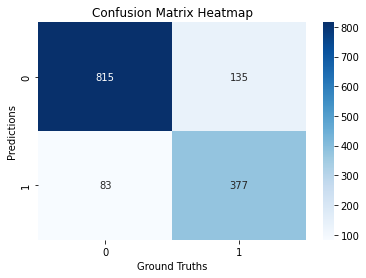

In [97]:
# Create a neural network
adam128_covid = BasicNeuralNetwork(
    input_size=X.shape[1],
    output_size=2,
    iterations=2500,
    logs=True,
    log_frequency=250,
    alpha=0.01,
    alpha_decay=0.0001,
    layer_size=128,
    optimizer="adam"
)

adam128_covid.train(X, y)
adam128_covid_confusion_matrix = evaluate_custom(X, y, adam128_covid)

visualize_custom(adam128_covid_confusion_matrix)

### **Results**

Let's split dataset into test and train sets and observe accuracies between optimizers. We will do this for each time window and then compare with Random Forest Classifier.

#### **Time Window 0-2**

In [98]:
dataset02 = pd.DataFrame(json.loads(datasets["window_0_2"]))

X = dataset02.drop("TARGET", axis=1).to_numpy()

y = dataset02[["TARGET"]].to_numpy()
y = one_hot(y.T[0], 2)

train_set, test_set = split_at_x_percent(X, 70)
train_truths, test_truths = split_at_x_percent(y, 70)

##### SGD

0: loss: 7.572, accuracy: 0.5061, learning_rate: 0.01
250: loss: 1.3521, accuracy: 0.664, learning_rate: 0.0098
500: loss: 0.7084, accuracy: 0.7166, learning_rate: 0.0095
750: loss: 0.484, accuracy: 0.7652, learning_rate: 0.0093
1000: loss: 0.3923, accuracy: 0.8138, learning_rate: 0.0091
1250: loss: 0.3368, accuracy: 0.8583, learning_rate: 0.0089
1500: loss: 0.3112, accuracy: 0.8745, learning_rate: 0.0087
1750: loss: 0.2937, accuracy: 0.9109, learning_rate: 0.0085
2000: loss: 0.2794, accuracy: 0.9069, learning_rate: 0.0083
2250: loss: 0.2672, accuracy: 0.915, learning_rate: 0.0082
Finished learning. Accuracy: 0.9190283400809717.
RESULTS:

    TP: 27,
    TN: 41,
    FP: 23,
    FN: 14
    accuracy: 68 / 105 = 64.76%
    sensitivity: 0.66
    specificity: 0.64
    


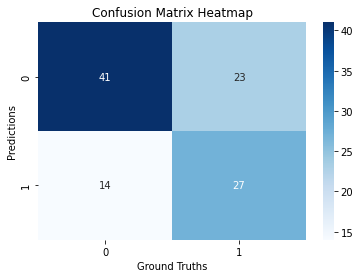

In [99]:
# Create a neural network
sgd128_covid = BasicNeuralNetwork(
    input_size=train_set.shape[1],
    output_size=2,
    iterations=2500,
    logs=True,
    log_frequency=250,
    alpha=0.01,
    alpha_decay=0.0001,
    layer_size=128
)

sgd128_covid.train(train_set, train_truths)
sgd128_covid_confusion_matrix = evaluate_custom(test_set, test_truths, sgd128_covid)

visualize_custom(sgd128_covid_confusion_matrix)


##### AdaGrad

0: loss: 3.8728, accuracy: 0.5547, learning_rate: 0.01
250: loss: 2.2235, accuracy: 0.6356, learning_rate: 0.0098
500: loss: 0.7597, accuracy: 0.7652, learning_rate: 0.0095
750: loss: 0.5597, accuracy: 0.7773, learning_rate: 0.0093
1000: loss: 0.4166, accuracy: 0.8219, learning_rate: 0.0091
1250: loss: 0.3342, accuracy: 0.8704, learning_rate: 0.0089
1500: loss: 0.2827, accuracy: 0.8907, learning_rate: 0.0087
1750: loss: 0.2409, accuracy: 0.915, learning_rate: 0.0085
2000: loss: 0.2225, accuracy: 0.9312, learning_rate: 0.0083
2250: loss: 0.2069, accuracy: 0.9433, learning_rate: 0.0082
Finished learning. Accuracy: 0.9433198380566802.
RESULTS:

    TP: 27,
    TN: 43,
    FP: 21,
    FN: 14
    accuracy: 70 / 105 = 66.67%
    sensitivity: 0.66
    specificity: 0.67
    


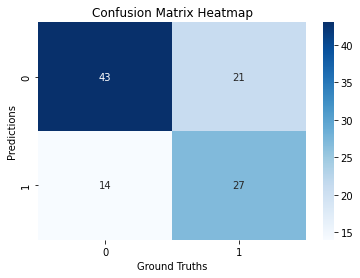

In [100]:
# Create a neural network
adagrad128_covid = BasicNeuralNetwork(
    input_size=train_set.shape[1],
    output_size=2,
    iterations=2500,
    logs=True,
    log_frequency=250,
    alpha=0.01,
    alpha_decay=0.0001,
    layer_size=128,
    optimizer="adagrad"
)

adagrad128_covid.train(train_set, train_truths)
adagrad128_covid_confusion_matrix = evaluate_custom(test_set, test_truths, adagrad128_covid)

visualize_custom(adagrad128_covid_confusion_matrix)

##### Adam

0: loss: 7.8061, accuracy: 0.4939, learning_rate: 0.01
250: loss: 1.62, accuracy: 0.6154, learning_rate: 0.0098
500: loss: 0.7418, accuracy: 0.7126, learning_rate: 0.0095
750: loss: 0.5038, accuracy: 0.7976, learning_rate: 0.0093
1000: loss: 0.3925, accuracy: 0.83, learning_rate: 0.0091
1250: loss: 0.3303, accuracy: 0.8704, learning_rate: 0.0089
1500: loss: 0.2854, accuracy: 0.8988, learning_rate: 0.0087
1750: loss: 0.2614, accuracy: 0.915, learning_rate: 0.0085
2000: loss: 0.2456, accuracy: 0.9231, learning_rate: 0.0083
2250: loss: 0.234, accuracy: 0.9312, learning_rate: 0.0082
Finished learning. Accuracy: 0.9392712550607287.
RESULTS:

    TP: 17,
    TN: 43,
    FP: 21,
    FN: 24
    accuracy: 60 / 105 = 57.14%
    sensitivity: 0.41
    specificity: 0.67
    


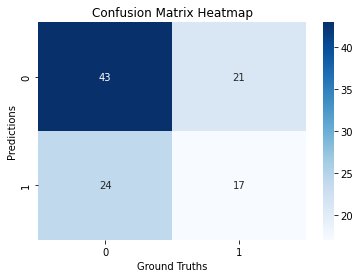

In [101]:
# Create a neural network
adam128_covid = BasicNeuralNetwork(
    input_size=train_set.shape[1],
    output_size=2,
    iterations=2500,
    logs=True,
    log_frequency=250,
    alpha=0.01,
    alpha_decay=0.0001,
    layer_size=128,
    optimizer="adam"
)

adam128_covid.train(train_set, train_truths)
adam128_covid_confusion_matrix = evaluate_custom(test_set, test_truths, adam128_covid)

visualize_custom(adam128_covid_confusion_matrix)

##### Random Forest

Accuracy: 0.6792452830188679
Sensitivity: 0.57
Specificity: 0.8


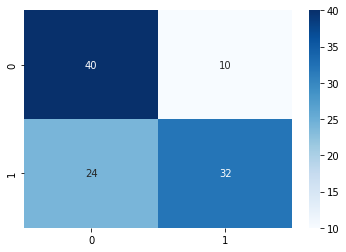

In [102]:
(test, pred) = random_forest(df=pd.DataFrame(json.loads(datasets["window_0_2"])), target="TARGET")

evaluation = evaluate(test, pred)
visualize_confusion_matrix(test, pred)
print(evaluation)

#### **Time Window 2-4**

In [103]:
dataset02 = pd.DataFrame(json.loads(datasets["window_2_4"]))

X = dataset02.drop("TARGET", axis=1).to_numpy()

y = dataset02[["TARGET"]].to_numpy()
y = one_hot(y.T[0], 2)

train_set, test_set = split_at_x_percent(X, 70)
train_truths, test_truths = split_at_x_percent(y, 70)

##### SGD

0: loss: 4.7045, accuracy: 0.6616, learning_rate: 0.01
250: loss: 1.0701, accuracy: 0.7761, learning_rate: 0.0098
500: loss: 0.5926, accuracy: 0.8207, learning_rate: 0.0095
750: loss: 0.4333, accuracy: 0.8409, learning_rate: 0.0093
1000: loss: 0.3665, accuracy: 0.8551, learning_rate: 0.0091
1250: loss: 0.3091, accuracy: 0.8673, learning_rate: 0.0089
Finished learning. Accuracy: 0.889564336372847.
RESULTS:

    TP: 61,
    TN: 241,
    FP: 61,
    FN: 59
    accuracy: 302 / 422 = 71.56%
    sensitivity: 0.51
    specificity: 0.8
    


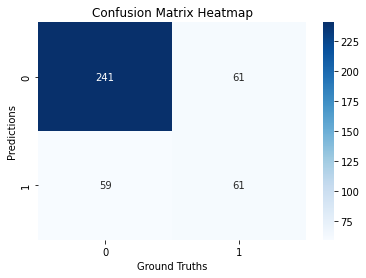

In [127]:
# Create a neural network
sgd128_covid = BasicNeuralNetwork(
    input_size=train_set.shape[1],
    output_size=2,
    iterations=1500,
    logs=True,
    log_frequency=250,
    alpha=0.01,
    alpha_decay=0.0001,
    layer_size=128,
    momentum=0.3
)

sgd128_covid.train(train_set, train_truths)
sgd128_covid_confusion_matrix = evaluate_custom(test_set, test_truths, sgd128_covid)

visualize_custom(sgd128_covid_confusion_matrix)


##### AdaGrad

0: loss: 4.3048, accuracy: 0.4792, learning_rate: 0.01
250: loss: 1.6274, accuracy: 0.7508, learning_rate: 0.0098
500: loss: 0.8932, accuracy: 0.7801, learning_rate: 0.0095
750: loss: 0.609, accuracy: 0.8055, learning_rate: 0.0093
1000: loss: 0.4589, accuracy: 0.8288, learning_rate: 0.0091
1250: loss: 0.381, accuracy: 0.848, learning_rate: 0.0089
Finished learning. Accuracy: 0.8662613981762918.
RESULTS:

    TP: 49,
    TN: 260,
    FP: 42,
    FN: 71
    accuracy: 309 / 422 = 73.22%
    sensitivity: 0.41
    specificity: 0.86
    


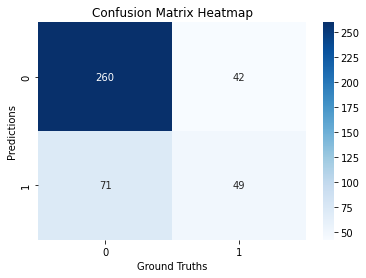

In [128]:
# Create a neural network
adagrad128_covid = BasicNeuralNetwork(
    input_size=train_set.shape[1],
    output_size=2,
    iterations=1500,
    logs=True,
    log_frequency=250,
    alpha=0.01,
    alpha_decay=0.0001,
    layer_size=128,
    optimizer="adagrad"
)

adagrad128_covid.train(train_set, train_truths)
adagrad128_covid_confusion_matrix = evaluate_custom(test_set, test_truths, adagrad128_covid)

visualize_custom(adagrad128_covid_confusion_matrix)

##### Adam

0: loss: 6.0278, accuracy: 0.4255, learning_rate: 0.01
250: loss: 1.603, accuracy: 0.7467, learning_rate: 0.0098
500: loss: 0.8676, accuracy: 0.7741, learning_rate: 0.0095
750: loss: 0.6115, accuracy: 0.8095, learning_rate: 0.0093
1000: loss: 0.4901, accuracy: 0.8227, learning_rate: 0.0091
1250: loss: 0.4177, accuracy: 0.8389, learning_rate: 0.0089
Finished learning. Accuracy: 0.8571428571428571.
RESULTS:

    TP: 55,
    TN: 265,
    FP: 37,
    FN: 65
    accuracy: 320 / 422 = 75.83%
    sensitivity: 0.46
    specificity: 0.88
    


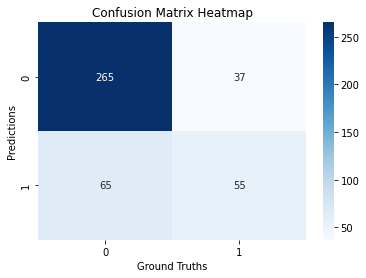

In [129]:
# Create a neural network
adam128_covid = BasicNeuralNetwork(
    input_size=train_set.shape[1],
    output_size=2,
    iterations=1500,
    logs=True,
    log_frequency=250,
    alpha=0.01,
    alpha_decay=0.0001,
    layer_size=128,
    optimizer="adam"
)

adam128_covid.train(train_set, train_truths)
adam128_covid_confusion_matrix = evaluate_custom(test_set, test_truths, adam128_covid)

visualize_custom(adam128_covid_confusion_matrix)

##### Random Forest

Accuracy: 0.7794117647058824
Sensitivity: 0.7
Specificity: 0.85


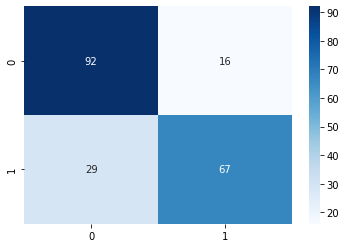

In [137]:
(test, pred) = random_forest(df=pd.DataFrame(json.loads(datasets["window_2_4"])), target="TARGET")

evaluation = evaluate(test, pred)
visualize_confusion_matrix(test, pred)
print(evaluation)

#### **Time Window 4-6**

In [108]:
dataset02 = pd.DataFrame(json.loads(datasets["window_4_6"]))

X = dataset02.drop("TARGET", axis=1).to_numpy()

y = dataset02[["TARGET"]].to_numpy()
y = one_hot(y.T[0], 2)

train_set, test_set = split_at_x_percent(X, 70)
train_truths, test_truths = split_at_x_percent(y, 70)

##### SGD

0: loss: 5.2557, accuracy: 0.6555, learning_rate: 0.01
250: loss: 0.3669, accuracy: 0.8379, learning_rate: 0.0098
500: loss: 0.2561, accuracy: 0.8946, learning_rate: 0.0095
750: loss: 0.2241, accuracy: 0.9119, learning_rate: 0.0093
1000: loss: 0.1968, accuracy: 0.925, learning_rate: 0.0091
1250: loss: 0.173, accuracy: 0.9422, learning_rate: 0.0089
Finished learning. Accuracy: 0.9523809523809523.
RESULTS:

    TP: 58,
    TN: 242,
    FP: 60,
    FN: 62
    accuracy: 300 / 422 = 71.09%
    sensitivity: 0.48
    specificity: 0.8
    


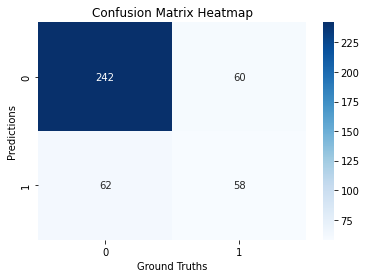

In [152]:
# Create a neural network
sgd128_covid = BasicNeuralNetwork(
    input_size=train_set.shape[1],
    output_size=2,
    iterations=1500,
    logs=True,
    log_frequency=250,
    alpha=0.01,
    alpha_decay=0.0001,
    layer_size=128,
    momentum=0.9
)

sgd128_covid.train(train_set, train_truths)
sgd128_covid_confusion_matrix = evaluate_custom(test_set, test_truths, sgd128_covid)

visualize_custom(sgd128_covid_confusion_matrix)


##### AdaGrad

0: loss: 5.3136, accuracy: 0.6555, learning_rate: 0.01
250: loss: 1.4793, accuracy: 0.7082, learning_rate: 0.0098
500: loss: 0.8551, accuracy: 0.7548, learning_rate: 0.0095
750: loss: 0.6277, accuracy: 0.769, learning_rate: 0.0093
1000: loss: 0.4919, accuracy: 0.7994, learning_rate: 0.0091
1250: loss: 0.4258, accuracy: 0.8176, learning_rate: 0.0089
Finished learning. Accuracy: 0.828774062816616.
RESULTS:

    TP: 77,
    TN: 209,
    FP: 93,
    FN: 43
    accuracy: 286 / 422 = 67.77%
    sensitivity: 0.64
    specificity: 0.69
    


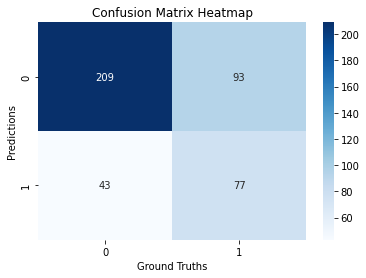

In [156]:
# Create a neural network
adagrad128_covid = BasicNeuralNetwork(
    input_size=train_set.shape[1],
    output_size=2,
    iterations=1500,
    logs=True,
    log_frequency=250,
    alpha=0.01,
    alpha_decay=0.0001,
    layer_size=128,
    optimizer="adagrad"
)

adagrad128_covid.train(train_set, train_truths)
adagrad128_covid_confusion_matrix = evaluate_custom(test_set, test_truths, adagrad128_covid)

visualize_custom(adagrad128_covid_confusion_matrix)

##### Adam

0: loss: 4.7886, accuracy: 0.6545, learning_rate: 0.01
250: loss: 1.6624, accuracy: 0.7396, learning_rate: 0.0098
500: loss: 0.9234, accuracy: 0.7781, learning_rate: 0.0095
750: loss: 0.6351, accuracy: 0.7974, learning_rate: 0.0093
1000: loss: 0.4792, accuracy: 0.8126, learning_rate: 0.0091
1250: loss: 0.4002, accuracy: 0.8338, learning_rate: 0.0089
Finished learning. Accuracy: 0.867274569402229.
RESULTS:

    TP: 53,
    TN: 255,
    FP: 47,
    FN: 67
    accuracy: 308 / 422 = 72.99%
    sensitivity: 0.44
    specificity: 0.84
    


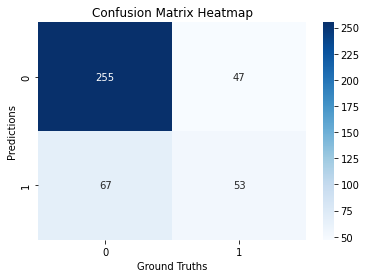

In [157]:
# Create a neural network
adam128_covid = BasicNeuralNetwork(
    input_size=train_set.shape[1],
    output_size=2,
    iterations=1500,
    logs=True,
    log_frequency=250,
    alpha=0.01,
    alpha_decay=0.0001,
    layer_size=128,
    optimizer="adam"
)

adam128_covid.train(train_set, train_truths)
adam128_covid_confusion_matrix = evaluate_custom(test_set, test_truths, adam128_covid)

visualize_custom(adam128_covid_confusion_matrix)

##### Random Forest

Accuracy: 0.8689655172413793
Sensitivity: 0.76
Specificity: 0.95


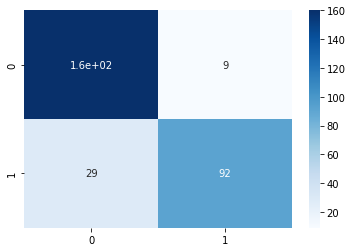

In [112]:
(test, pred) = random_forest(df=pd.DataFrame(json.loads(datasets["window_4_6"])), target="TARGET")

evaluation = evaluate(test, pred)
visualize_confusion_matrix(test, pred)
print(evaluation)

#### **Time Window 6-12**

In [113]:
dataset02 = pd.DataFrame(json.loads(datasets["window_6_12"]))

X = dataset02.drop("TARGET", axis=1).to_numpy()

y = dataset02[["TARGET"]].to_numpy()
y = one_hot(y.T[0], 2)

train_set, test_set = split_at_x_percent(X, 70)
train_truths, test_truths = split_at_x_percent(y, 70)

##### SGD

0: loss: 8.4483, accuracy: 0.3414, learning_rate: 0.01
250: loss: 0.2714, accuracy: 0.8896, learning_rate: 0.0098
500: loss: 0.2163, accuracy: 0.9169, learning_rate: 0.0095
750: loss: 0.1802, accuracy: 0.9443, learning_rate: 0.0093
1000: loss: 0.1525, accuracy: 0.9534, learning_rate: 0.0091
1250: loss: 0.1313, accuracy: 0.9635, learning_rate: 0.0089
Finished learning. Accuracy: 0.9696048632218845.
RESULTS:

    TP: 61,
    TN: 241,
    FP: 61,
    FN: 59
    accuracy: 302 / 422 = 71.56%
    sensitivity: 0.51
    specificity: 0.8
    


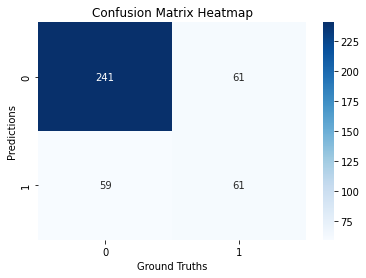

In [158]:
# Create a neural network
sgd128_covid = BasicNeuralNetwork(
    input_size=train_set.shape[1],
    output_size=2,
    iterations=1500,
    logs=True,
    log_frequency=250,
    alpha=0.01,
    alpha_decay=0.0001,
    layer_size=128,
    momentum=0.9
)

sgd128_covid.train(train_set, train_truths)
sgd128_covid_confusion_matrix = evaluate_custom(test_set, test_truths, sgd128_covid)

visualize_custom(sgd128_covid_confusion_matrix)


##### AdaGrad

0: loss: 9.5769, accuracy: 0.3435, learning_rate: 0.01
250: loss: 1.9012, accuracy: 0.7345, learning_rate: 0.0098
500: loss: 0.9274, accuracy: 0.7923, learning_rate: 0.0095
750: loss: 0.6991, accuracy: 0.8156, learning_rate: 0.0093
1000: loss: 0.5748, accuracy: 0.8207, learning_rate: 0.0091
1250: loss: 0.4998, accuracy: 0.8217, learning_rate: 0.0089
Finished learning. Accuracy: 0.828774062816616.
RESULTS:

    TP: 47,
    TN: 270,
    FP: 32,
    FN: 73
    accuracy: 317 / 422 = 75.12%
    sensitivity: 0.39
    specificity: 0.89
    


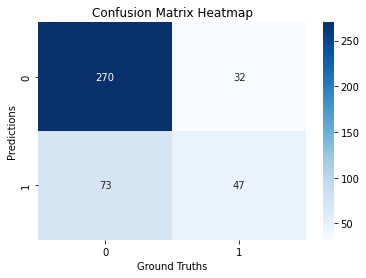

In [162]:
# Create a neural network
adagrad128_covid = BasicNeuralNetwork(
    input_size=train_set.shape[1],
    output_size=2,
    iterations=1500,
    logs=True,
    log_frequency=250,
    alpha=0.01,
    alpha_decay=0.0001,
    layer_size=128,
    optimizer="adagrad"
)

adagrad128_covid.train(train_set, train_truths)
adagrad128_covid_confusion_matrix = evaluate_custom(test_set, test_truths, adagrad128_covid)

visualize_custom(adagrad128_covid_confusion_matrix)

##### Adam

0: loss: 3.1919, accuracy: 0.536, learning_rate: 0.01
250: loss: 1.2863, accuracy: 0.7031, learning_rate: 0.0098
500: loss: 0.7085, accuracy: 0.7812, learning_rate: 0.0095
750: loss: 0.5509, accuracy: 0.8116, learning_rate: 0.0093
1000: loss: 0.4644, accuracy: 0.8227, learning_rate: 0.0091
1250: loss: 0.4106, accuracy: 0.8338, learning_rate: 0.0089
Finished learning. Accuracy: 0.8449848024316109.
RESULTS:

    TP: 79,
    TN: 215,
    FP: 87,
    FN: 41
    accuracy: 294 / 422 = 69.67%
    sensitivity: 0.66
    specificity: 0.71
    


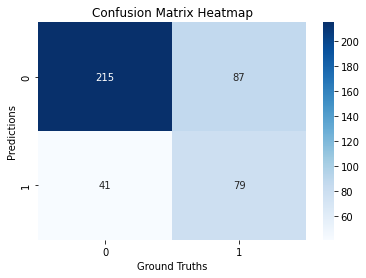

In [163]:
# Create a neural network
adam128_covid = BasicNeuralNetwork(
    input_size=train_set.shape[1],
    output_size=2,
    iterations=1500,
    logs=True,
    log_frequency=250,
    alpha=0.01,
    alpha_decay=0.0001,
    layer_size=128,
    optimizer="adam"
)

adam128_covid.train(train_set, train_truths)
adam128_covid_confusion_matrix = evaluate_custom(test_set, test_truths, adam128_covid)

visualize_custom(adam128_covid_confusion_matrix)

##### Random Forest

Accuracy: 0.8989071038251366
Sensitivity: 0.8
Specificity: 0.95


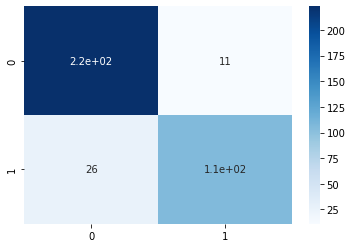

In [117]:
(test, pred) = random_forest(df=pd.DataFrame(json.loads(datasets["window_6_12"])), target="TARGET")

evaluation = evaluate(test, pred)
visualize_confusion_matrix(test, pred)
print(evaluation)

#### **Time Window All**

In [118]:
dataset02 = pd.DataFrame(json.loads(datasets["window_all"]))

X = dataset02.drop("TARGET", axis=1).to_numpy()

y = dataset02[["TARGET"]].to_numpy()
y = one_hot(y.T[0], 2)

train_set, test_set = split_at_x_percent(X, 70)
train_truths, test_truths = split_at_x_percent(y, 70)

##### SGD

0: loss: 5.3136, accuracy: 0.6555, learning_rate: 0.01
250: loss: 0.2971, accuracy: 0.8784, learning_rate: 0.0098
500: loss: 0.2475, accuracy: 0.9058, learning_rate: 0.0095
750: loss: 0.2134, accuracy: 0.921, learning_rate: 0.0093
1000: loss: 0.1845, accuracy: 0.9321, learning_rate: 0.0091
1250: loss: 0.1606, accuracy: 0.9463, learning_rate: 0.0089
1500: loss: 0.1407, accuracy: 0.9514, learning_rate: 0.0087
1750: loss: 0.1241, accuracy: 0.9615, learning_rate: 0.0085
2000: loss: 0.1102, accuracy: 0.9696, learning_rate: 0.0083
2250: loss: 0.0982, accuracy: 0.9747, learning_rate: 0.0082
Finished learning. Accuracy: 0.977710233029382.
RESULTS:

    TP: 66,
    TN: 230,
    FP: 72,
    FN: 54
    accuracy: 296 / 422 = 70.14%
    sensitivity: 0.55
    specificity: 0.76
    


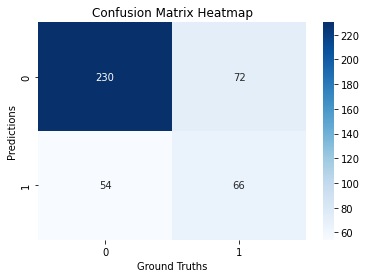

In [164]:
# Create a neural network
sgd128_covid = BasicNeuralNetwork(
    input_size=train_set.shape[1],
    output_size=2,
    iterations=2500,
    logs=True,
    log_frequency=250,
    alpha=0.01,
    alpha_decay=0.0001,
    layer_size=128,
    momentum=0.9
)

sgd128_covid.train(train_set, train_truths)
sgd128_covid_confusion_matrix = evaluate_custom(test_set, test_truths, sgd128_covid)

visualize_custom(sgd128_covid_confusion_matrix)


##### AdaGrad

0: loss: 3.5795, accuracy: 0.4995, learning_rate: 0.01
250: loss: 1.191, accuracy: 0.7042, learning_rate: 0.0098
500: loss: 0.6865, accuracy: 0.7649, learning_rate: 0.0095
750: loss: 0.5067, accuracy: 0.7943, learning_rate: 0.0093
1000: loss: 0.4149, accuracy: 0.8186, learning_rate: 0.0091
1250: loss: 0.368, accuracy: 0.8409, learning_rate: 0.0089
Finished learning. Accuracy: 0.8581560283687943.
RESULTS:

    TP: 69,
    TN: 229,
    FP: 73,
    FN: 51
    accuracy: 298 / 422 = 70.62%
    sensitivity: 0.57
    specificity: 0.76
    


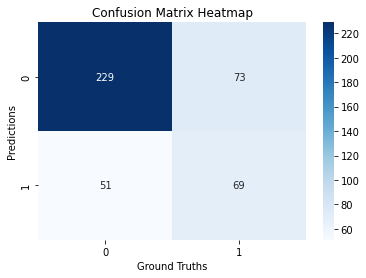

In [165]:
# Create a neural network
adagrad128_covid = BasicNeuralNetwork(
    input_size=train_set.shape[1],
    output_size=2,
    iterations=1500,
    logs=True,
    log_frequency=250,
    alpha=0.01,
    alpha_decay=0.0001,
    layer_size=128,
    optimizer="adagrad"
)

adagrad128_covid.train(train_set, train_truths)
adagrad128_covid_confusion_matrix = evaluate_custom(test_set, test_truths, adagrad128_covid)

visualize_custom(adagrad128_covid_confusion_matrix)

##### Adam

0: loss: 10.0505, accuracy: 0.3435, learning_rate: 0.01
250: loss: 1.509, accuracy: 0.7052, learning_rate: 0.0098
500: loss: 0.8704, accuracy: 0.7751, learning_rate: 0.0095
750: loss: 0.641, accuracy: 0.8065, learning_rate: 0.0093
1000: loss: 0.5243, accuracy: 0.8267, learning_rate: 0.0091
1250: loss: 0.4479, accuracy: 0.847, learning_rate: 0.0089
Finished learning. Accuracy: 0.8409321175278622.
RESULTS:

    TP: 80,
    TN: 216,
    FP: 86,
    FN: 40
    accuracy: 296 / 422 = 70.14%
    sensitivity: 0.67
    specificity: 0.72
    


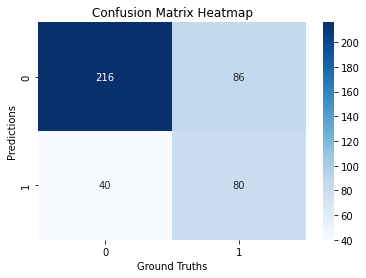

In [167]:
# Create a neural network
adam128_covid = BasicNeuralNetwork(
    input_size=train_set.shape[1],
    output_size=2,
    iterations=1500,
    logs=True,
    log_frequency=250,
    alpha=0.01,
    alpha_decay=0.0001,
    layer_size=128,
    optimizer="adam"
)

adam128_covid.train(train_set, train_truths)
adam128_covid_confusion_matrix = evaluate_custom(test_set, test_truths, adam128_covid)

visualize_custom(adam128_covid_confusion_matrix)

##### Random Forest

Accuracy: 0.9219858156028369
Sensitivity: 0.82
Specificity: 0.97


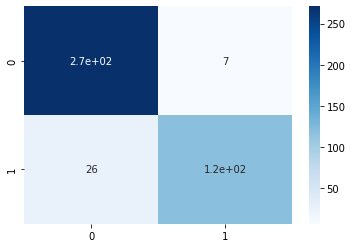

In [168]:
(test, pred) = random_forest(df=pd.DataFrame(json.loads(datasets["window_all"])), target="TARGET")

evaluation = evaluate(test, pred)
visualize_confusion_matrix(test, pred)
print(evaluation)

### Result table

#### Accuracy

| **Algorithm** | **0-2** | **2-4** | **4-6** | **6-12** | **All** |
| ------------- | :-----: | :-----: | :-----: | :------: | :-----: |
| NN(*SGD*)     | 65%     | 72%     | 71%     | 72%      | 70%     |
| NN(*AdaGrad*) | **67%** | 73%     | 68%     | **75%**  | 71%     |
| NN(*Adam*)    | 57%     | **75%** | **73%** | 70%      | 70%     |
|*Random Forest*| *68%*   | *78%*   | *87%*   | *90%*    | *89%*   |


#### Sensitivity

| **Algorithm** | **0-2** | **2-4** | **4-6** | **6-12** | **All** |
| ------------- | :-----: | :-----: | :-----: | :------: | :-----: |
| NN(*SGD*)     | **66%** | **51%** | 48%     | 51%      | 55%     |
| NN(*AdaGrad*) | **66%** | 41%     | **64%** | 39%      | 57%     |
| NN(*Adam*)    | 41%     | 46%     | 44%     | **66%**  | **67%** |
|*Random Forest*| *57%*   | *70%*   | *76%*   | *80%*    | *82%*   |

#### Specificity

| **Algorithm** | **0-2** | **2-4** | **4-6** | **6-12** | **All** |
| ------------- | :-----: | :-----: | :-----: | :------: | :-----: |
| NN(*SGD*)     | 64%     | 80%     | 80%     | 80%      | **76%** |
| NN(*AdaGrad*) | **67%** | 86%     | 69%     | **89%**  | **76%** |
| NN(*Adam*)    | **67%** | **88%** | **84%** | 71%      | 72%     |
|*Random Forest*| *80%*   | *85%*   | *95%*   | *95%*    | *97%*   |